<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [2]:
def get_video_frames(path, no_frames = 1000):
    """
    Gets a path to the video to be read
    Args:
        path: string to the path of the video
        no_frames: int, specifies the number of frames to be read from the video
    Returns:
        a list of complete frames. Each complete frame is a list containing the Y,Cb,Cr components of each frame
    """
    vid = cv2.VideoCapture(path)
    # Initialize a np array to hold all frames.
    vid_frame = []
    # Read until video is completed
    for i in range(no_frames):
            if vid.isOpened() == 0:
                print("couldn't open video")
            # Capture frame-by-frame
            ret, frameRGB = vid.read()
            if ret == True:
                # Convert frame to YUV with 4:2:0 sampling
                frameYUV = cv2.cvtColor(frameRGB, cv2.COLOR_RGB2YUV_I420)

                # Get frame components
                rows, cols = frameYUV.shape 
                Y_row = np.int(rows - rows*1/3)
                frame_Y = frameYUV[0:Y_row, :]

                frame_Cb1 = frameYUV[Y_row:np.int(Y_row*1.25),0: np.int(cols/2)]
                frame_Cr1 = frameYUV[np.int(Y_row*1.25):np.int(Y_row*1.5), 0: np.int(cols/2)]

                frame_Cb2 = frameYUV[Y_row:np.int(Y_row*1.25), np.int(cols/2):]
                frame_Cr2 = frameYUV[np.int(Y_row*1.25):np.int(Y_row*1.5), np.int(cols/2):]

                complete_frame = np.array([frame_Y,frame_Cb1,frame_Cr1,frame_Cb2,frame_Cr2])

                # Add frame to list of frames
                vid_frame.append(complete_frame)
            # Break the loop
            else: 
                break
    return vid_frame

In [3]:
def reshape_image(image, box_size = 16):

    n_rows = np.int(np.floor(image.shape[0]/box_size))
    n_cols = np.int(np.floor(image.shape[1]/box_size))

    image_array = cv2.resize(image, dsize=(n_cols*box_size, n_rows*box_size))
    return image_array

In [4]:
def get_sub_images(image_array, box_size=16):
    """
    Gets a grayscale image and returns an array of (box_size, box_size) elements
    Args:
        image_array (numpy ndarray): Image input we want to divide to box
                                     sub_images.
         Should have shape (length, width, n_channels) where length = width
          e. g. n_channels = 3 for RGB
         box_size (int): Size of the box sub images
    Returns:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
         - should have a shape of (X, box_size, box_size, n_channels).
        n_rows: number of rows or blocks
        n_cols: number of columns in image
          the number of blocks is n_rows*n_cols
    """
    n_rows = np.int(image_array.shape[0]/box_size)
    n_cols = np.int(image_array.shape[1]/box_size)

    # make the image into a square to simplify operations based
    #  on the smaller dimension
    # d = min(n_cols, n_rows)

    # Note: images are converted to uint8 datatypes since they range between
    #  0-255. different datatypes might misbehave (based on my trials)
    image_blocks = np.asarray([np.zeros((box_size, box_size), dtype='uint8')
                               for i in range(n_rows*n_cols)], dtype='uint8')

    # break down the image into blocks
    c = 0
    for i in range(n_rows):
        for j in range(n_cols):
            image_blocks[c] = image_array[i*box_size: i*box_size+box_size,
                                          j*box_size:j*box_size+box_size]
            c += 1

    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_blocks, n_rows, n_cols

In [5]:
def get_reconstructed_image(divided_image, n_rows, n_cols, box_size=8):
    """
    Gets an array of (box_size,box_size) pixels
    and returns the reconstructed image
    Args:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
        n_rows: number of rows or blocks
        n_cols: number of columns in image
            the number of blocks is n_rows*n_cols
        box_size (int): Size of the box sub images
    Returns:
        reconstructed_image (numpy ndarray): Image reconstructed from the array
        of divided images.

    """
    image_reconstructed = np.zeros((n_rows*box_size, n_cols*box_size), dtype=np.uint8)
    c = 0
    # break down the image into blocks
    for i in range(n_rows):
        for j in range(n_cols):
            image_reconstructed[i*box_size: i*box_size+box_size, 
                                j*box_size:j*box_size+box_size] = divided_image[c]
            c += 1
            
    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_reconstructed


Dimensions of the ref image is  (720, 960)
Dimensions of the ref divided is (2700, 16, 16)


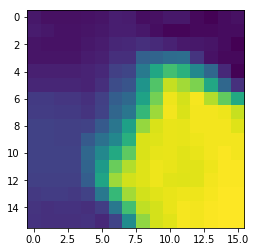

In [11]:
vid_frame = get_video_frames('mountain.mp4')
im_blocks_ref, n_rows, n_cols = get_sub_images(reshape_image(vid_frame[0][0]))
im_blocks_p, __, __ = get_sub_images(reshape_image(vid_frame[300][0]))
print('Dimensions of the ref image is ', vid_frame[0][0].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

plt.imshow(im_blocks_ref[1700])

In [12]:
def rmse(im, ref_im):
    """
    Gets the root mean squared error between 2 images
    Args:
         im (numpy array) : The current image
         ref_im (numpy ndarray): The reference image
    Returns:
        rmse: root mean squared error as a metric to compare between the original image and the reconstructed
    """
    error = ref_im - im
    mse = np.sum(np.square(error)) / (im.shape[0] * im.shape[1])
    rmse = np.sqrt(mse)

    return rmse


def motion_estimation(ref_frame, current_block, block_num, n_rows, n_cols, search_size = 128):
    """
    Gets the search area from the reference frame, and the current 16x16 frame block
    and returns the motion vector by subtracting the matched MxN frame block in 
    the search area from the current MxN frame block.
    Args:
        ref_frame: the reference frame
        current_block: a block of 16x16 pixels from the current frame. 
        block_num: a tuple containing the i and j values of the image block. Corresponds to the row and column that the block
        resides in
        search_size: the size of the search_area as a whole.
    Returns:
        motion_vector: the coordinate distance change (in pixel units) between the current frame and reference frame.
    """
    # Pad the image with the search_size specified at the borders of the image
    # This ensures that the search area will never be outside the boundaries of the image
    h, w = ref_frame.shape
    border_width = int(search_size/2) - 8
    padded = np.zeros(( h + border_width*2, w + border_width*2))  # Initialize an array of zeros 
    # Add the reference frame to this array, so that we have a new frame with padded borders of size 64 on each edge
    padded[border_width : h+border_width, border_width: w+border_width] = ref_frame 
    
    # find the matching 16x16 block from the search_area
    # Convert this row and column number to x and y coordinates
    row, col = block_num
    block_size = current_block.shape[0]
    y, x = (block_size*(row), block_size*(col))
    
    
    # the whole search area is 128*128
    # The coordinates of the padded np array is different from the coordinates of the current block.
    # i.e the top left pixel of the current block when mapped to padded np.array, it becomes (x+border_width,y+border_width)
    search_area = padded[y : (y+ search_size), x : (x + search_size)]
    loss_prev = 1000
    c = 0
    for j in range(search_size -block_size):
        for i in range(search_size - block_size):
            c+=1
            loss = rmse(current_block, search_area[j:j+block_size,i:i+block_size])
            if loss < loss_prev:
                loss_prev = loss
                best_frame = search_area[j:j+block_size,i:i+block_size]
                y_moved, x_moved = (j,i)
    
    
    motion_vectors = (y_moved-border_width, x_moved-border_width)   
    
    return motion_vectors
   

def motion_estimation_to_all(ref_frame, current_frame, n_rows, n_cols, search_size =128):
    """
    Gets the reference frame (previous frame) and current frame. The prev_frame could be the k-nth frame where k is the current frame.
    and performs motion estimation on all 16x16 macroblocks in the current frame.
    Args:
        ref_frame: np array of the reference frame image
        current_frame: current frame image divided into 16x16 macroblocks of shape 
        - should have a shape of (X, macroblock_size, macroblock_size)
        n_rows: number of rows
        n_cols: number of columns
        search_size: the search area is search_size*2
    returns:
        motion_vectors: np array of size(X, 2) where each macroblock has a motion vector represented in 2 values in the x and y coordinates 
    """
    h, w = ref_frame.shape
    macroblock_size = current_frame.shape[1]
    motion_vectors = []
    # Loop over the whole array of macroblocks
    # to get the motion vectors
    for row in range(n_rows):
        for col in range(n_cols):
            motion_vectors.append(motion_estimation(ref_frame, current_frame[row*n_cols + col],  (row,col), n_rows, n_cols, search_size))
                                  
    return motion_vectors

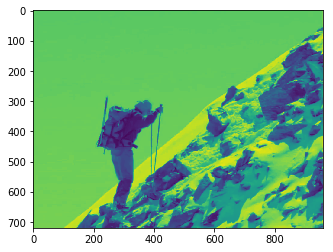

In [13]:
im_rec = get_reconstructed_image(im_blocks_ref, n_rows, n_cols, box_size=16)
plt.imshow(im_rec)

In [14]:
import time
ref_frame = vid_frame[0][0]
start = time.time()
mv = motion_estimation_to_all(ref_frame, im_blocks_p, n_rows, n_cols)
end = time.time()
print(" execution time: ", end-start)
mv

KeyboardInterrupt: 

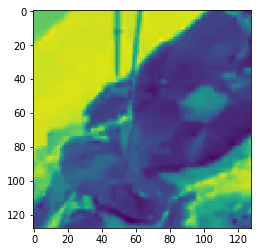

In [488]:
plt.imshow(ref_frame[560-58:560-58+128,400-58:400-58+128])

(16, 16)

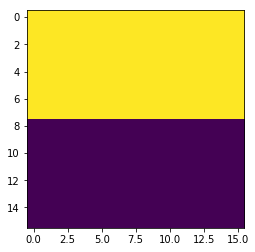

In [483]:
plt.imshow(vid_frame[0][16:16+16, 912:912+16])
vid_frame[0][16:16+16, 912:912+16].shape

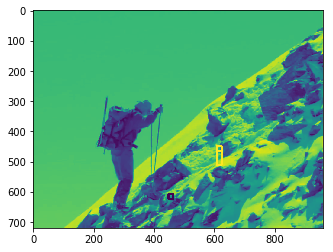

In [318]:
search_size = 128
border_width = int(search_size/2) - 8
srch = vid_frame[0][608-border_width:608-border_width+search_size, 448-border_width:448-border_width+search_size]

plt.imshow(cv2.rectangle(vid_frame[0],(608,448),(608+16,448+16), (255, 0, 0), 5))